## Victor Moraes - 2016027600

## Quarto trabalho pratico de reconhecimento de padrões
# SVM - Máquinas de vetores de suporte


# Introdução

Neste trabalho, será aplicado o classificador SVM na resolução de um problema de classificação sintético, analisando aspectos e estratégias de sintonia de hiperparametros.

## 1- Conjunto de testes
Inicialmente importaremos as bibliotecas necessárias e em seguida criaremos o conjunto de amostras. O conjunto forma 2 espirais com defasagem entre elas. Apresenta uma dificuldade a classificadores lineares, por se tratar de uma separação não linear.

Criou-se 1000 pontos de amostras com ruido embutido.

In [1]:
import numpy as np
from numpy.random import normal, uniform
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from matplotlib.ticker import LinearLocator, ScalarFormattertlib.colors import Normalize
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [2]:
def twospirals(n_points, noise=1.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 540 * (2*np.pi)/360
    #n[n%(2*np.pi)<1] = n[n%(2*np.pi)<1] + np.pi*np.ones(n[n%(2*np.pi)<1].size)/2
    min_radius=3
    n[n<min_radius] = n[n<min_radius] + min_radius*np.ones(n[n<min_radius].size)
    d1x = np.cos(n)*n + np.random.rand(n_points,1) * noise  
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    phase=np.pi
    d2x = np.cos(n+phase)*n + np.random.rand(n_points,1) * noise  
    d2y = np.sin(n+phase)*n + np.random.rand(n_points,1) * noise 
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((d2x,d2y)))), 
            np.hstack((-np.ones(n_points),np.ones(n_points))))

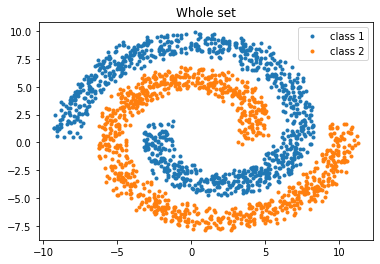

In [3]:
X, y = twospirals(1000, noise=2)

plt.title('Whole set')
plt.plot(X[y==-1,0], X[y==-1,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

<p style="page-break-after:always;"></p>

## Separação de conjuntos de treinamento e testes

Neste ponto é realizada a separação de amostras de treino e validação iniciais.


In [4]:
xlim=[-10,10]
ylim=[-10,10]
test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=0)

## 3 Treinamento inicial do modelo, com parametros a determinar.

Será utilizado a implementação SVC, ou classificação de vetores de suporte. Nesta implementação é permitido que os pontos não sejam necessariamente linearmente separáveis, sendo o desvio tolerável ditado pelo parâmetro C. Outro parametro é o gamma, representado na equação a seguir por sigma. É um parâmetro do kernel que determina a geometria e curvatura do superplano de classificação.    
Aqui é utilizado o kernel radial : $K(x_i,x_j)= exp(-\frac{||x_i-x_j||}{2\sigma^2})$
Foi escolhido pois a distribuição da dispersão dos pontos é radial.

Para a escolha de C e gama, adiante será feita varredura e de forma que evite overfitting e maximize a média de acertos.

In [5]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
error = pred-y_test
pred[pred==0]

array([], dtype=float64)

In [6]:
def print_score(x,y):
    score = 100* clf.score(X_test,y_test)
    print("Score de: {:2.2f}%\n".format(score))

print_score(X_test,y_test)

Score de: 98.00%



In [7]:
def svm_plot(X, f , display_support=False):
    plt.title('training set')
    plt.plot(X[pred==-1,0], X[pred==-1,1], '.', label='class 1')
    plt.plot(X[pred==1,0], X[pred==1,1], '.', label='class 2')
    plt.legend()

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = f(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
    # plot support vectors
    if(display_support):
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=30,
                   linewidth=1, facecolors='none', edgecolors='k')
    plt.show()

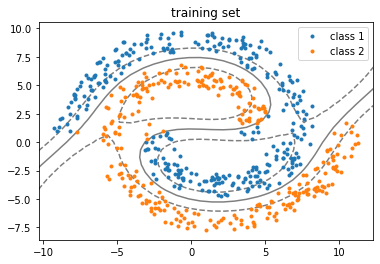

In [8]:
svm_plot(X_test,clf.decision_function)


<p style="page-break-after:always;"></p>

## 3.b
Os valores padrões do método são C=1 e gamma=1/2X.var() = 0.020  
Como foram utilizados argumentos padrões da biblioteca, os ajustes não estão completamente adequados.  
Pode-se observar que as margens não seguiram o formateo de espiral, com undefitting.

In [9]:
1/(2*X_train.var())

0.02074632799816441

In [10]:
# Metodo de normalizar o heatplot

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## 3.c Definição dos parametros do kernel por meio de grid search

Aqui é realizado pesquisa em rede, para determinação numérica dos parametros com melhor desempenho.   
Para cada par de parametro C e gamma, é realizado um treinamento com k-fold validation, com 5 grupos,    
a partir das amostras geradas.  

In [19]:
C_range = np.logspace(-4, 4, 16)
gamma_range = np.logspace(-4, 4, 16)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(SVC(), param_grid=param_grid, n_jobs=3)
grid.fit(X, y)
grid.best_params_

{'C': 0.0001, 'gamma': 0.5411695265464638}

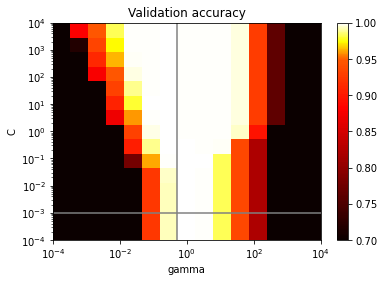

In [20]:
scores_plot = np.reshape(grid.cv_results_['mean_test_score'],(C_range.shape[0],gamma_range.shape[0]))
gamma_plot = grid.cv_results_['param_gamma']
c_plot = grid.cv_results_['param_C']
plt.axvline(0.5, color='gray')
plt.axhline(0.001, color='gray')
X_mesh,Y_mesh=np.meshgrid(C_range,gamma_range)
Z = scores_plot
im = plt.pcolor(X_mesh,Y_mesh,Z, cmap=plt.cm.hot,norm=MidpointNormalize(vmin=0.7, midpoint=0.95))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar(im, orientation='vertical')
plt.title('Validation accuracy')
plt.show()

## 3.d Escolha de modelo
Como pode-se ver a seguir, a biblioteca seleciona o primeiro melhor estimador na métrica de escore, que foi o seguinte:  
SVC(C=0.001, gamma=0.49238826317067363)

Contudo pode não ser o melhor modelo, como veremos a seguir.

É possivel determinar que há um pouco de overfitting, pois a fronteira de separação está encapsulando as amostras e a margem tendeu a valores altos


The best parameters are {'C': 0.0001, 'gamma': 0.5411695265464638} with a score of 1.00


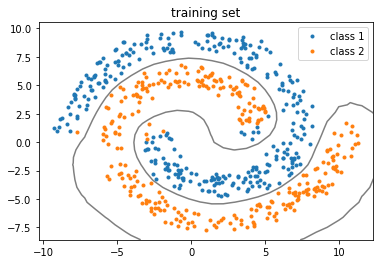

In [21]:
best_estimator = grid.best_estimator_
final_score = best_estimator.score(X_test, y_test)
print("The best parameters are %s with a score of %0.2f"  % (grid.best_params_, final_score))
best_estimator.decision_function

svm_plot(X_test,best_estimator.decision_function)

## 3.e Busca de parametros na região de desempenho
Como o modelo determinado automaticamente não é satisfatório,  
optou-se procurar outros parametros na região de melhor desempenho.

Escolheu-se os parametros: 
C=10000
Gamma=0.02

Neste é possivel observar a margem de separação entre as duas classificações. Ademais, não há overfitting.

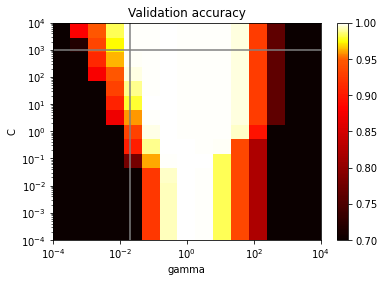

In [22]:

im = plt.pcolor(X_mesh,Y_mesh,Z, cmap=plt.cm.hot,norm=MidpointNormalize(vmin=0.7, midpoint=0.95))
plt.axvline(0.02, color='gray')
plt.axhline(1000, color='gray')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar(im, orientation='vertical')
plt.title('Validation accuracy')
plt.show()

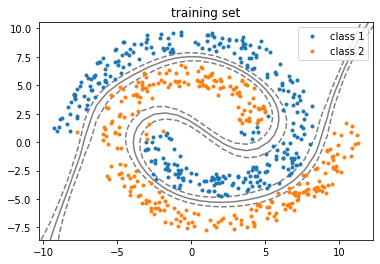

The best parameters are  C=1000, gamma=0.02 with a score of 100.00%


In [23]:
choosen_estimator = SVC(C=1000,gamma=0.02).fit(X_train,y_train)
f = choosen_estimator.decision_function
svm_plot(X_test, f)
final_score = choosen_estimator.score(X_test, y_test)
print("The best parameters are  C=1000, gamma=0.02 with a score of {:.2f}%".format(100*final_score))

## 3. Conclusão

Aqui podemos observar que o classificador apresenta margens e hiperplano de separação razoáveis,  
e desempenho melhor do que outros modelos apresentados anteriormente.

## 4. Vetores de Suporte

São as amostras de froteira com maior influência para determinação do problema de otimização de determinação do vetor de pesos.

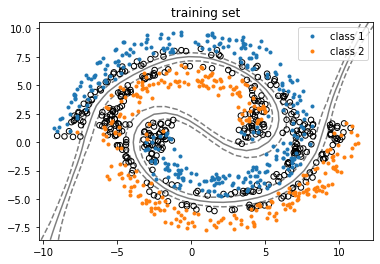

In [24]:
choosen_estimator = SVC(C=1000,gamma=0.02).fit(X_train,y_train)
f = choosen_estimator.decision_function
svm_plot(X_test, f, display_support=True)

<p style="page-break-after:always;"></p>

## 5. Superficie de separação

Aqui é exibida a superficie de separação que separa os espaços de cada classifacação.

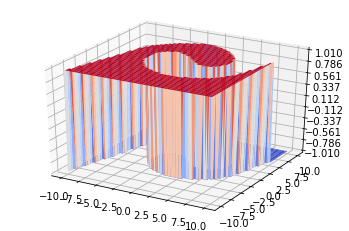

In [25]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
xx = np.linspace(xlim[0],xlim[1],100)
yy = np.linspace(ylim[0],ylim[1],100)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
ZZ = f(xy).reshape(XX.shape)
ZZ[ZZ>0] = 1
ZZ[ZZ<0] = -1
surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
plt.show()

# Conclusão


Neste trabalho foi aplicar o algoritmo de vetores de suporte de maquina, que é uma classificação linear,  
para classificar um problema não linear, por meio de transformação de espaço. Foi transformado em um espaço radial,  
assim linearizando o problema. O metodo,  classificou satisfatoriamente, embora exista ruido e margens pequenas.

## Referências:

C support vector classification - SciKitLearn
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC  


Gridsearch - SciKitLearn
https://scikit-learn.org/stable/modules/grid_search.html#grid-search